**Necessary Imports**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime
from sklearn.mixture import GaussianMixture

**Loading the datasets**

In [18]:
# Load the datasets
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")
products = pd.read_csv("Products.csv")



**EDA**

In [19]:
encoder = OneHotEncoder(sparse_output=False, drop="first")



# Merge data on CustomerID and ProductID
data = pd.merge(transactions, customers, on="CustomerID", how="inner")
data = pd.merge(data, products, on="ProductID", how="inner")


# Aggregate features
agg_transactions = data.groupby("CustomerID").agg({
    "TotalValue": "sum",  # Total Spend
    "Quantity": "sum",  # Total Quantity Purchased
    "TransactionID": "count",  # Purchase Frequency
}).reset_index()

agg_transactions.columns = ["CustomerID", "TotalSpend","TotalQuantity", "PurchaseFrequency"]
customer_features = pd.merge(customers, agg_transactions, on="CustomerID", how="left")
# print(customer_features)

region_encoded = encoder.fit_transform(data[["Region"]])
region_df = pd.DataFrame(region_encoded, columns=encoder.get_feature_names_out(["Region"]))

# print(region_df.index)
# customer_features = pd.concat([customer_features, region_df], axis=1)
customer_features = customer_features.drop(columns=["CustomerID", "CustomerName", "SignupDate","PurchaseFrequency","Region"])

# Display the customer features
customer_features.head()

,TotalSpend,TotalQuantity
0,3354.52,12.0
1,1862.74,10.0
2,2725.38,14.0
3,5354.88,23.0
4,2034.24,7.0


**Checking for duplicates or null values**

In [12]:
# Remove duplicates
customer_features = customer_features.drop_duplicates()

# Fill missing values
# You can fill missing values with the mean for numerical columns or mode for categorical columns.
customer_features.fillna({
    'TotalSpend': customer_features['TotalSpend'].mean(),
    'TotalQuantity': customer_features['TotalQuantity'].mean(),
    #'PurchaseFrequency': customer_features['PurchaseFrequency'].mean(),
    # 'Region': customer_features['Region'].mean()
}, inplace=True)

# Verify the changes
print(customer_features.isnull().sum())  # To check if any null values remain

TotalSpend       0
TotalQuantity    0
dtype: int64


**Scaling the features to bring them into a common scale**

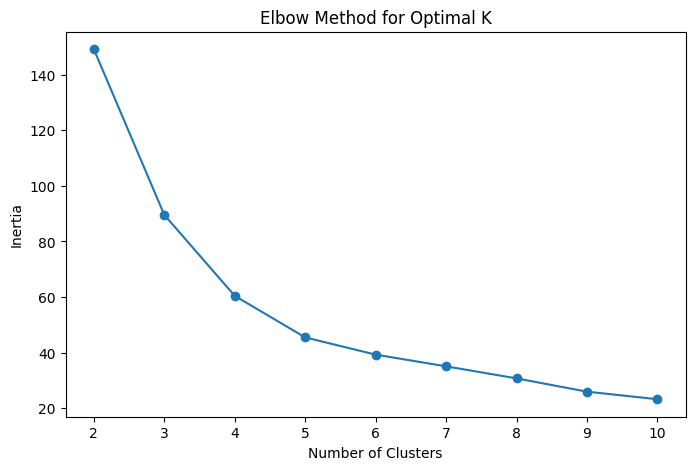

In [13]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_features)

inertia = []
k_values = range(2, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    #kmeans = KMediods(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()

**Clustering Operation and Accuracy Metrics**

In [14]:
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
#kmeans = KMedoids(n_clusters=optimal_k, random_state=42)
#kmeans = AgglomerativeClustering(n_clusters=optimal_k)
#kmeans = GaussianMixture(n_components=optimal_k, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

db_index = davies_bouldin_score(scaled_data, clusters)
sil_score = silhouette_score(scaled_data, clusters)
ch_score = calinski_harabasz_score(scaled_data, clusters)
ari_score = adjusted_rand_score(clusters, clusters)
mi_score = normalized_mutual_info_score(clusters, clusters)

print(f"Davies-Bouldin Index: {db_index}")
print(f"Silhouette Score: {sil_score}")
print(f"Calinski-Harabasz Index: {ch_score}")
print(f"Adjusted Rand Index (ARI): {ari_score}")
print(f"Mutual Information (MI): {mi_score}")

Davies-Bouldin Index: 0.6309092148907892
Silhouette Score: 0.5477870037078584
Calinski-Harabasz Index: 333.18407830098846
Adjusted Rand Index (ARI): 1.0
Mutual Information (MI): 1.0


**Visualising the Clusters Formation and Separation**

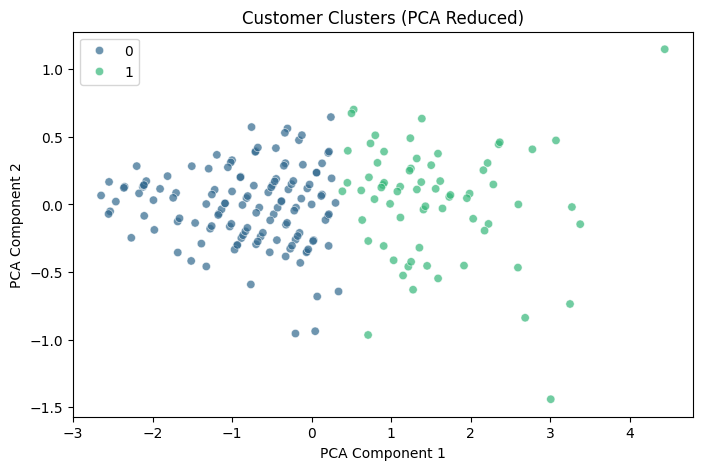

In [17]:
customer_features["Cluster"] = clusters
# PCA for Visualization
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=clusters, palette="viridis", alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Customer Clusters (PCA Reduced)")
plt.show()